# FactShield: Data Preprocessing Pipeline

**Purpose:** Clean and prepare text data for machine learning

## What We'll Do:
1. Load raw data
2. Build text cleaning pipeline
3. Validate data quality
4. Create train/validation/test splits
5. Save processed datasets

---

## Step 1: Load Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Text processing
import re
import string

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Train/test split
from sklearn.model_selection import train_test_split

# Path handling
import os
from pathlib import Path

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
%matplotlib inline

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


## Step 2: Download NLTK Data

We need several NLTK resources for text processing:

In [2]:
# Download required NLTK data
nltk_data = ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger', 'omw-1.4']

print("Downloading NLTK data...")
for package in nltk_data:
    try:
        nltk.download(package, quiet=True)
        print(f"✅ {package}")
    except Exception as e:
        print(f"⚠️ {package}: {e}")

print("\n✅ NLTK data ready!")

✅ punkt
✅ stopwords
✅ wordnet
✅ averaged_perceptron_tagger
✅ omw-1.4

✅ NLTK data ready!


## Step 3: Load Raw Data

In [3]:
# Find data files (same logic as notebook 01)
def find_data_path():
    """Find the data/raw directory"""
    relative_paths = [
        Path('../data/raw'),
        Path('data/raw'),
    ]
    
    for path in relative_paths:
        if path.exists() and (path / 'Fake.csv').exists():
            return path
    
    # Search for Fake.csv starting from home directory
    print("Searching for data files...")
    for csv_file in Path.home().rglob('Fake.csv'):
        if (csv_file.parent / 'True.csv').exists():
            return csv_file.parent
    
    raise FileNotFoundError("Could not find data files.")

# Load data
data_path = find_data_path()
print(f"Loading data from: {data_path}\n")

fake_df = pd.read_csv(data_path / 'Fake.csv')
true_df = pd.read_csv(data_path / 'True.csv')

# Add labels
fake_df['label'] = 1  # 1 = fake
true_df['label'] = 0  # 0 = real

# Combine
df = pd.concat([fake_df, true_df], ignore_index=True)

print(f"✅ Loaded {len(df):,} articles")
print(f"   Fake: {len(fake_df):,}")
print(f"   Real: {len(true_df):,}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nDataset shape: {df.shape}")

Searching for data files...
Loading data from: C:\Users\btakiso\.cache\kagglehub\datasets\clmentbisaillon\fake-and-real-news-dataset\versions\1

✅ Loaded 44,898 articles
   Fake: 23,481
   Real: 21,417

Columns: ['title', 'text', 'subject', 'date', 'label']

Dataset shape: (44898, 5)


## Step 4: Initial Data Quality Check

In [4]:
print("=== Data Quality Check ===")
print(f"\nMissing values per column:")
print(df.isnull().sum())

print(f"\nDuplicate rows: {df.duplicated().sum()}")

print(f"\nData types:")
print(df.dtypes)

print(f"\nSample article (Real):")
sample_real = df[df['label'] == 0].iloc[0]
print(f"Title: {sample_real['title'][:100]}...")
print(f"Text: {sample_real['text'][:200]}...")

print(f"\nSample article (Fake):")
sample_fake = df[df['label'] == 1].iloc[0]
print(f"Title: {sample_fake['title'][:100]}...")
print(f"Text: {sample_fake['text'][:200]}...")

=== Data Quality Check ===

Missing values per column:
title      0
text       0
subject    0
date       0
label      0
dtype: int64

Duplicate rows: 209

Data types:
title      object
text       object
subject    object
date       object
label       int64
dtype: object

Sample article (Real):
Title: As U.S. budget fight looms, Republicans flip their fiscal script...
Text: WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal ...

Sample article (Fake):
Title:  Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing...
Text: Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former rea...


## Step 5: Text Cleaning Pipeline

### Why Each Step Matters:

1. **Lowercase** - "Trump" and "trump" should be treated the same
2. **Remove URLs** - Links don't help detect fake news patterns
3. **Remove special characters** - Focus on words, not punctuation
4. **Remove extra whitespace** - Clean formatting

In [5]:
def clean_text(text):
    """
    Clean text for ML processing
    
    Args:
        text (str): Raw text
        
    Returns:
        str: Cleaned text
    """
    if pd.isna(text):
        return ""
    
    # Convert to string
    text = str(text)
    
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 3. Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # 4. Remove special characters and digits (keep letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # 5. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Test the function
test_text = "BREAKING NEWS!!! Visit https://example.com for more info. Contact us at news@fake.com."
print("Original:")
print(test_text)
print("\nCleaned:")
print(clean_text(test_text))
print("\n✅ Cleaning function works!")

Original:
BREAKING NEWS!!! Visit https://example.com for more info. Contact us at news@fake.com.

Cleaned:
breaking news visit for more info contact us at

✅ Cleaning function works!


## Step 6: Advanced Text Processing (Tokenization & Lemmatization)

In [6]:
def process_text_advanced(text, remove_stopwords=False):
    """
    Advanced text processing with tokenization and lemmatization
    
    Args:
        text (str): Cleaned text
        remove_stopwords (bool): Whether to remove stopwords
        
    Returns:
        str: Processed text
    """
    if not text:
        return ""
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords (optional - can lose important context)
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        # Keep some important words that might matter for fake news
        keep_words = {'not', 'no', 'never', 'neither', 'nor', 'but', 'against'}
        stop_words = stop_words - keep_words
        tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Remove very short words (1-2 characters)
    tokens = [word for word in tokens if len(word) > 2]
    
    return ' '.join(tokens)

# Test the function
test_text = "the president is running for elections and making promises to voters"
print("Original:")
print(test_text)
print("\nProcessed (with stopwords):")
print(process_text_advanced(test_text, remove_stopwords=False))
print("\n✅ Advanced processing works!")

Original:
the president is running for elections and making promises to voters

Processed (with stopwords):
the president running for election and making promise voter

✅ Advanced processing works!


## Step 7: Apply Cleaning to Full Dataset

**Note:** We'll keep stopwords for now. Research shows they can be useful for fake news detection!

In [7]:
print("Starting text preprocessing...\n")
print("This may take a few minutes for 44k articles...")

# Create a copy to work with
df_processed = df.copy()

# Combine title and text for more context
df_processed['full_text'] = df_processed['title'] + ' ' + df_processed['text']

# Apply basic cleaning
print("\n[1/2] Applying basic cleaning...")
df_processed['cleaned_text'] = df_processed['full_text'].apply(clean_text)
print("✅ Basic cleaning complete")

# Apply advanced processing (keeping stopwords)
print("\n[2/2] Applying tokenization and lemmatization...")
df_processed['processed_text'] = df_processed['cleaned_text'].apply(
    lambda x: process_text_advanced(x, remove_stopwords=False)
)
print("✅ Advanced processing complete")

print(f"\n✅ Preprocessing complete!")
print(f"   Processed {len(df_processed):,} articles")

Starting text preprocessing...

This may take a few minutes for 44k articles...

[1/2] Applying basic cleaning...
✅ Basic cleaning complete

[2/2] Applying tokenization and lemmatization...
✅ Advanced processing complete

✅ Preprocessing complete!
   Processed 44,898 articles


## Step 8: Quality Check - Before vs After

In [8]:
# Show examples of preprocessing
print("=== EXAMPLE 1: Real News ===")
sample_idx = df_processed[df_processed['label'] == 0].index[5]
print("\nORIGINAL:")
print(df_processed.loc[sample_idx, 'full_text'][:300])
print("\nPROCESSED:")
print(df_processed.loc[sample_idx, 'processed_text'][:300])

print("\n" + "="*60)
print("\n=== EXAMPLE 2: Fake News ===")
sample_idx = df_processed[df_processed['label'] == 1].index[5]
print("\nORIGINAL:")
print(df_processed.loc[sample_idx, 'full_text'][:300])
print("\nPROCESSED:")
print(df_processed.loc[sample_idx, 'processed_text'][:300])

=== EXAMPLE 1: Real News ===

ORIGINAL:
White House, Congress prepare for talks on spending, immigration WEST PALM BEACH, Fla./WASHINGTON (Reuters) - The White House said on Friday it was set to kick off talks next week with Republican and Democratic congressional leaders on immigration policy, government spending and other issues that ne

PROCESSED:
white house congress prepare for talk spending immigration west palm beach flawashington reuters the white house said friday set kick off talk next week with republican and democratic congressional leader immigration policy government spending and other issue that need wrapped early the new year the


=== EXAMPLE 2: Fake News ===

ORIGINAL:
 Racist Alabama Cops Brutalize Black Boy While He Is In Handcuffs (GRAPHIC IMAGES) The number of cases of cops brutalizing and killing people of color seems to see no end. Now, we have another case that needs to be shared far and wide. An Alabama woman by the name of Angela Williams shared a graphic

PR

## Step 9: Remove Empty or Very Short Texts

In [9]:
print("Removing empty or very short texts...\n")

# Count word length
df_processed['word_count'] = df_processed['processed_text'].apply(lambda x: len(x.split()))

print(f"Articles with < 10 words: {(df_processed['word_count'] < 10).sum()}")
print(f"Articles with 0 words: {(df_processed['word_count'] == 0).sum()}")

# Remove articles with fewer than 10 words (likely corrupted)
before_count = len(df_processed)
df_processed = df_processed[df_processed['word_count'] >= 10].copy()
after_count = len(df_processed)

print(f"\n✅ Removed {before_count - after_count} low-quality articles")
print(f"   Remaining: {after_count:,} articles")

Removing empty or very short texts...

Articles with < 10 words: 122
Articles with 0 words: 9

✅ Removed 122 low-quality articles
   Remaining: 44,776 articles


## Step 10: Create Train/Validation/Test Splits

**Split Strategy:**
- **70% Training** - Learn patterns
- **15% Validation** - Tune hyperparameters
- **15% Test** - Final evaluation (never seen by model)

**Stratified Split:** Maintains class balance (50/50 fake/real) in each set

In [10]:
print("Creating train/validation/test splits...\n")

# First split: 70% train, 30% temp (val + test)
train_df, temp_df = train_test_split(
    df_processed,
    test_size=0.30,
    random_state=42,
    stratify=df_processed['label']
)

# Second split: Split temp into 50/50 (15% val, 15% test)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=temp_df['label']
)

print("✅ Splits created!\n")
print("=== Dataset Sizes ===")
print(f"Training:   {len(train_df):,} articles ({len(train_df)/len(df_processed)*100:.1f}%)")
print(f"Validation: {len(val_df):,} articles ({len(val_df)/len(df_processed)*100:.1f}%)")
print(f"Test:       {len(test_df):,} articles ({len(test_df)/len(df_processed)*100:.1f}%)")
print(f"Total:      {len(df_processed):,} articles")

print("\n=== Class Balance Check ===")
for name, dataset in [('Training', train_df), ('Validation', val_df), ('Test', test_df)]:
    fake_pct = (dataset['label'] == 1).sum() / len(dataset) * 100
    real_pct = (dataset['label'] == 0).sum() / len(dataset) * 100
    print(f"{name:12} - Fake: {fake_pct:.1f}% | Real: {real_pct:.1f}%")

Creating train/validation/test splits...

✅ Splits created!

=== Dataset Sizes ===
Training:   31,343 articles (70.0%)
Validation: 6,716 articles (15.0%)
Test:       6,717 articles (15.0%)
Total:      44,776 articles

=== Class Balance Check ===
Training     - Fake: 52.2% | Real: 47.8%
Validation   - Fake: 52.2% | Real: 47.8%
Test         - Fake: 52.2% | Real: 47.8%


## Step 11: Visualize Split Quality

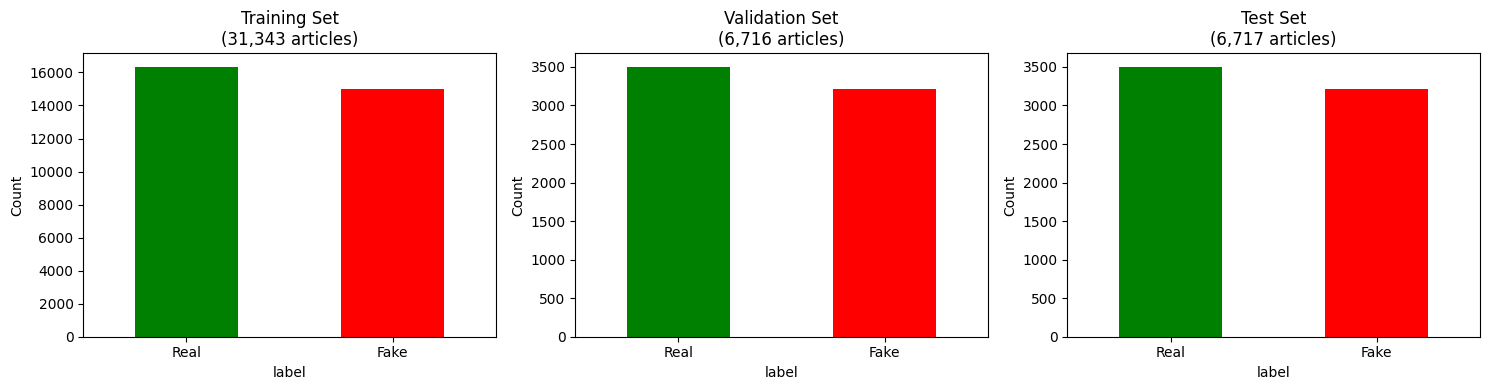

✅ All splits are well-balanced!


In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, dataset) in enumerate([('Training', train_df), ('Validation', val_df), ('Test', test_df)]):
    dataset['label'].value_counts().plot(kind='bar', ax=axes[idx], color=['green', 'red'])
    axes[idx].set_title(f'{name} Set\n({len(dataset):,} articles)')
    axes[idx].set_xticklabels(['Real', 'Fake'], rotation=0)
    axes[idx].set_ylabel('Count')

plt.tight_layout()
plt.show()

print("✅ All splits are well-balanced!")

## Step 12: Save Processed Datasets

In [ ]:
# Get project's processed data directory
def get_processed_path():
    """Get the data/processed directory in the project folder"""
    # Try relative paths first
    possible_paths = [
        Path('../data/processed'),  # From notebooks/ folder
        Path('data/processed'),      # From project root
    ]
    
    for path in possible_paths:
        if path.parent.exists():  # Check if data/ folder exists
            path.mkdir(exist_ok=True)
            return path.resolve()
    
    # If relative paths don't work, search for FactShield project
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / 'data').exists() and (parent / 'notebooks').exists():
            # This is the FactShield project root
            processed_path = parent / 'data' / 'processed'
            processed_path.mkdir(exist_ok=True)
            return processed_path
    
    raise FileNotFoundError("Could not find FactShield project directory")

# Save the datasets
processed_path = get_processed_path()
print(f"Saving processed datasets to: {processed_path}\n")
print(f"(This is your PROJECT folder, not the kagglehub cache)\n")

# Select columns to save
columns_to_save = ['title', 'text', 'processed_text', 'label', 'subject', 'date', 'word_count']

# Save each split
train_df[columns_to_save].to_csv(processed_path / 'train.csv', index=False)
print("✅ Saved train.csv")

val_df[columns_to_save].to_csv(processed_path / 'val.csv', index=False)
print("✅ Saved val.csv")

test_df[columns_to_save].to_csv(processed_path / 'test.csv', index=False)
print("✅ Saved test.csv")

print(f"\n✅ All processed datasets saved successfully!")

Saving processed datasets to: C:\Users\btakiso\.cache\kagglehub\datasets\clmentbisaillon\fake-and-real-news-dataset\versions\processed

✅ Saved train.csv
✅ Saved val.csv
✅ Saved test.csv

✅ All processed datasets saved successfully!


## Step 13: Final Summary & Statistics

In [13]:
print("="*60)
print("       DATA PREPROCESSING COMPLETE!")
print("="*60)

print("\n📊 SUMMARY STATISTICS:")
print(f"\nOriginal dataset:     {len(df):,} articles")
print(f"After cleaning:       {len(df_processed):,} articles")
print(f"Removed:              {len(df) - len(df_processed):,} articles")

print(f"\n📁 SAVED DATASETS:")
print(f"Training set:         {len(train_df):,} articles")
print(f"Validation set:       {len(val_df):,} articles")
print(f"Test set:             {len(test_df):,} articles")

print(f"\n📝 TEXT STATISTICS:")
print(f"Average words/article: {df_processed['word_count'].mean():.0f}")
print(f"Median words/article:  {df_processed['word_count'].median():.0f}")
print(f"Min words:             {df_processed['word_count'].min()}")
print(f"Max words:             {df_processed['word_count'].max()}")

print("\n✅ Ready for feature engineering!")
print("\n🔜 Next step: Notebook 03 - Feature Engineering (TF-IDF & Sentiment)")

       DATA PREPROCESSING COMPLETE!

📊 SUMMARY STATISTICS:

Original dataset:     44,898 articles
After cleaning:       44,776 articles
Removed:              122 articles

📁 SAVED DATASETS:
Training set:         31,343 articles
Validation set:       6,716 articles
Test set:             6,717 articles

📝 TEXT STATISTICS:
Average words/article: 327
Median words/article:  293
Min words:             10
Max words:             6452

✅ Ready for feature engineering!

🔜 Next step: Notebook 03 - Feature Engineering (TF-IDF & Sentiment)


---

## 🎯 What We Accomplished:

✅ **Loaded** 44,898 raw articles  
✅ **Cleaned** text (removed URLs, special chars, etc.)  
✅ **Processed** text (tokenization, lemmatization)  
✅ **Split** into train/val/test (70/15/15)  
✅ **Verified** class balance maintained  
✅ **Saved** processed datasets for next phase  

## 📚 Key Learnings:

1. **Text cleaning is crucial** - Removes noise that confuses models
2. **Keeping stopwords** can be useful for context
3. **Stratified splitting** ensures fair evaluation
4. **Data validation** catches quality issues early

---

**Next:** Feature engineering with TF-IDF vectorization & Sentiment Analysis 🚀